Oryginal source code was taken from repository of Michael Nielsen who heas great blog on fundamentlas of Neural networks.

- Repository:https://github.com/mnielsen/neural-networks-and-deep-learning.git
- Web site: http://neuralnetworksanddeeplearning.com/index.html

#### Code was modified by Damian Kolmas
- Modified at 25.11.2017
- Web site: https://dkolmas.github.io/
- Worth looking at link with types of figures: https://dvia.samizdat.cc/2017/tag/catalog/

In [141]:
#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import time
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [142]:
#N = 100 # Number of data points per single class
N = 100
D = 2   # Dimensionality of the data
K = 3   # Number of classes
np.random.seed(121)

In [143]:
X = np.zeros( (N * K, D) )          # shape (300, 2)
y = np.zeros( (N*K), dtype='uint8' )  # shape (300, ) - a kind of (single) row vector

# Generate toy data set
# loop for each class...`
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

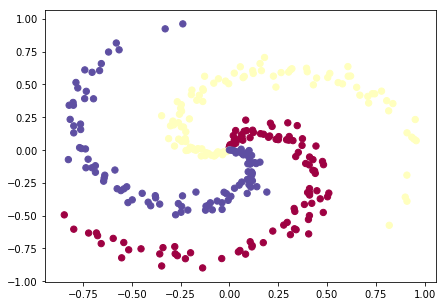

In [144]:
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [6]:
# Create a list of tuples that is used as an input into a network
training_data = [(x1,y1) for x1,y1 in zip(X,y)]

In [7]:
print("Data type of training_data:",type(training_data))
print("Number of samples: ",len(training_data))

Data type of training_data: <class 'list'>
Number of samples:  300


In [242]:
# Prepare test data

#N = 100 # Number of data points per single class
N = 100
D = 2   # Dimensionality of the data
K = 3   # Number of classes
np.random.seed(789)

In [243]:
X_test = np.zeros( (N * K, D) )          # shape (300, 2)
y_test = np.zeros( (N*K), dtype='uint8' )  # shape (300, ) - a kind of (single) row vector

# Generate toy data set
# loop for each class...`
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X_test[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y_test[ix] = j

In [244]:
# Create a list of tuples that is used as an input into a network
test_data = [(x1,y1) for x1,y1 in zip(X_test,y_test)]

In [109]:
#### Define the quadratic and cross-entropy cost functions

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)


# Cross entropy loss function with assumption of use for classification
# Derivative of loss function is made together with derivative of activation
# function which is softmax (or sigmoid for single output calssification)
class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        #return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
        return -1*np.log(a[y])

    @staticmethod
    # It is assumed that y indicates a class with numbers starting from 0,
    # for example for three different classes should be: 0, 1, 2
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        #return (a-y)
        output = a
        output[y] -= 1
        return output


In [209]:
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost, error_term_divided=1, weight_init=0,\
                 regOn=1):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  
        For example, if the list was [2, 3, 1] then it would be a 
        three-layer network, with the first layer containing 2 neurons, 
        the second layer 3 neurons, and the third layer 1 neuron.  
        
        The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        start = time.time()
        
        self.num_layers = len(sizes) # input, hidden and output layer
        self.sizes = sizes # Number of neurons in all layers (including input and output)
        self.cost=cost
        self.size_of_input = sizes[0]
        self.reg = 1e-3
        self.regOn = regOn  # if regOn - regularizer is used
        self.error_term_divided = error_term_divided
        
        if weight_init==0:
            # cs321 style
            self.biases = [np.zeros((y, 1)) for y in sizes[1:]]
            self.weights = [np.zeros((y, x)) for x, y in zip(sizes[:-1], sizes[1:])]
            np.random.seed(2020)
            self.weights[0] = 0.01 * np.random.randn(sizes[0],sizes[1])
            self.weights[1] = 0.01 * np.random.randn(sizes[1],sizes[2])
            self.weights[0] = self.weights[0].T
            self.weights[1] = self.weights[1].T
        elif weight_init==1:
            np.random.seed(2020)
            #self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
            #self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]  
            self.biases = [np.zeros((y, 1)) for y in sizes[1:]]
            self.weights = [0.01 * np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        elif weight_init==2:
            self.default_weight_initializer()
        elif weight_init==3:    
            self.large_weight_initializer()
        
        reg_loss = [0.5*self.reg*np.sum(W*W) for W in self.weights]         
        print("Reg loss w1: ", reg_loss[0])    
        print("Reg loss w2: ", reg_loss[1]) 
        
        print("Number of layers (input, hidden, output): ",self.num_layers)
        print("Indexing of layers: 0..",self.num_layers-1)
        print("Number of neurons in each layer: ",sizes) 
        print("Cost function:",cost)
        for k in range(self.num_layers-1):
            if (k == 0) | (k == self.num_layers-2) :
                if k == 0:
                    print(" Layer {0}  (the first hidden layer)".format(k+1))
                if k == self.num_layers-2:
                    print(" Layer {0}  (output layer)".format(k+1))
            else:
                print("Layer {0}".format(k+1))
                
            print("   Biases:  ",sizes[k+1], 1)
            print("   Weights: ",sizes[k+1], sizes[k])
            
        end = time.time()
        print("Time of initialization: ",(end-start))
        '''
        weights between two layers are made in a following way (dimensions):
        [ number of node of next layer, number of nodes of previuos layer]
        
        biases are made in following way (dimensions):
        [ number of nodes of the next layer, 1]
        '''
        
        #for b, w in zip(self.biases, self.weights):
        #    print( w, b)

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
            
    def feedforward(self, data):
        # Calculate network ouput using current weights values
        # The output is an array with a shape [n_outputs, n_samples]
        number_of_input_samples = len(data)
        
        Xin = [x_1[0] for x_1 in data ]
        Xin = np.array(Xin)
        Xin = np.reshape(Xin, (number_of_input_samples, -1))
        Xin = Xin.T
        
        for k in range (self.num_layers-2):
        #    print(" k ",k)
            b = self.biases[k]
            w = self.weights[k]
            relu_input = np.dot(w, Xin)+b
            Xin = relu(relu_input)
        
        # Calculation for the output layer
        b = self.biases[self.num_layers-2]
        w = self.weights[self.num_layers-2]
        scores = np.dot(w,Xin)+b
        Xout = softmax_all_data(scores)

        return Xout
    
    def evaluate_on_train_data(self, train_data):
        # Evaluate loss on training data 
        number_of_samples = len(train_data)
        y_correct_classes = [ y1[1] for y1 in train_data ]
        # The input is the list and the output is an array
        # with diemnnstions of [n_outputs, n_samples]
        network_output = self.feedforward(train_data)
        # Now diemnsions are: [n_samples, n_outputs]
        network_output = network_output.T
        corect_logprobs = \
                -np.log(network_output[range(number_of_samples),y_correct_classes])
        data_loss = np.sum(corect_logprobs)/number_of_samples
        
        # Calcuate regularizer loss
        reg_loss = [0.5*self.reg*np.sum(W*W) for W in self.weights]
        reg_loss = np.sum(reg_loss)
        total_loss = data_loss + reg_loss
        
        return data_loss, reg_loss, total_loss
        
    def SGD(self, training_data, epochs, mini_batch_size, eta, loss_dispaly_periodicity=10,
            test_data=None):
        """
        The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.
        Train the neural network using mini-batch stochastic
        gradient descent. The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        if test_data: n_test = len(test_data)
        n = len(training_data)
        number_of_training_samples = n
        print("Number of all training samples:",n)

        # Prepare arrays to store statistics of trainig
        if (epochs%loss_dispaly_periodicity == 0):
            num_track_samples = epochs/loss_dispaly_periodicity + 1
        else:
            num_track_samples = math.ceil(epochs/loss_dispaly_periodicity) + 1
        train_data_loss_out = np.zeros((int(num_track_samples),1))
        train_reg_loss_out = np.zeros((int(num_track_samples),1))
        train_total_loss_out = np.zeros((int(num_track_samples),1))
        test_data_loss_out = np.zeros((int(num_track_samples),1))
        test_reg_loss_out = np.zeros((int(num_track_samples),1))
        test_total_loss_out = np.zeros((int(num_track_samples),1))        
        out_idx_cnt = 0
        
        # Only one batch
        # The location of creating one mini batc here is temporary 
        # In order to guaratnee consistency with other scirpt
        mini_batches = [ training_data[k:k+mini_batch_size]
                         for k in range(0, n, mini_batch_size)]

        print("Size of the first mini batch: ", len(mini_batches[0]))
              
        #loss_dispaly_periodicity = np.floor(epochs/10)
        total_time = 0
        
        for j in range(epochs):

            # print end record loss - make an function (j, total_time, train_data, test_data)
            if ( j==0 or (j%loss_dispaly_periodicity)==0 or j==(epochs-1) ):
                if 0:
                    print("Epoch {0}: {1} / {2}"\
                        .format(j, self.evaluate(test_data), n_test))
                else:
                    Average_mini_batch_run_time = total_time/(loss_dispaly_periodicity*len(mini_batches))
                    total_time = 0
                    train_data_loss, train_reg_loss, train_total_loss \
                            = self.evaluate_on_train_data(training_data)
                    print("Epoch {0}: Data loss: {1:.4f}, Reg loss: {2:.4f}, Total loss: {3:.8f},  Av time: {4:.5f}"\
                          .format(j, train_data_loss, train_reg_loss, train_total_loss, Average_mini_batch_run_time))
                    train_data_loss_out[out_idx_cnt] = train_data_loss
                    train_reg_loss_out[out_idx_cnt] = train_reg_loss
                    train_total_loss_out[out_idx_cnt] = train_total_loss
                    if test_data:
                        test_data_loss, test_reg_loss, test_total_loss \
                                = self.evaluate_on_train_data(test_data)
                        test_data_loss_out[out_idx_cnt] = test_data_loss
                        test_reg_loss_out[out_idx_cnt] = test_reg_loss
                        test_total_loss_out[out_idx_cnt] = test_total_loss
                    
                    out_idx_cnt += 1

            
            # Apply mini-batches
            #random.shuffle(training_data)                        
            #mini_batches = [ training_data[k:k+mini_batch_size]
            #                 for k in range(0, n, mini_batch_size)]
            
            for mini_batch in mini_batches:
                start = time.time()
                #update weights and biases for one mini batch
                self.update_network_with_one_mini_batch(mini_batch, eta)
                end = time.time()
                total_time += (end-start)
                
        return [train_data_loss_out, train_reg_loss_out, train_total_loss_out, \
                test_data_loss_out, test_reg_loss_out, test_total_loss_out, \
                self.weights, self.biases]
            

    def update_network_with_one_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        
        # Create a list of arrays
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # For EACH SAMPLE in the mini batch...
        for x, y in mini_batch:
            # ..calculate delta weight and delta bias 
            # (list of arrays - each array for a purpose of separate layer)
            delta_nabla_w, delta_nabla_b  = self.backprop(x, y, len(mini_batch))
                
            # ..and keep adding that so to get sum of delta of 
            # weights and biase for all smples in mini bach
            # "internal" for loop here is to accumulate delat weights and delta bias
            # for each layer separately (a list of arrays is created for biases and weigths)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
                
        # Add regularizer
        if self.regOn==1:
            nabla_w = [dW+(self.reg*W) for dW, W in zip(nabla_w,self.weights)]
        
        # After all samples from mini batch were used to calculate
        # cumulative delta of weights and biases
        if self.error_term_divided == 1:
            self.weights = [w-(eta)*nw for w, nw in zip(self.weights, nabla_w)]
            self.biases =  [b-(eta)*nb for b, nb in zip(self.biases, nabla_b)]
        else:
            self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
            self.biases =  [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

        
    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
        
    def backprop(self, x, y, mini_batch_size=1):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        # Convert 1D input into 2D input where the second dimension is 1
        # The conversion is ncessary for correct dot product operation np.dot
        x.shape = (self.size_of_input,1)
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        layer_number = 1 # layer counter in forward pass
        # forward pass for each layer...
        for b, w in zip(self.biases, self.weights):
            layer_number = layer_number + 1
            # input for the activation function            
            z = np.dot(w, activation)+b
            # keep the input for the latter use            
            zs.append(z)
            
            if layer_number==self.num_layers:
                activation = softmax(z)
            else:
                #activation = sigmoid(z)
                activation = relu(z)
            # Keep the output of the acitvation function
            activations.append(activation)
        # activation contains output starting from the first hidden layer
        
        # backward pass
        # Currently it is assumed that sigmoid activation function is used at the output
        # The three line of code below refers to calculation of delta (error term) only
        # for the last layer (which is output layer)
        # NOTE: "-1" index refers to the last layer (output layer)
        
        # Derivative of cost function combined with derivative of output activation function
        #delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        
        # New 26.11.2017
        if self.error_term_divided == 1:
            # Reduce the error term by dividing by number of samples in current mini batch size
            delta /= mini_batch_size
        
        nabla_b[-1] = delta
        # Outer porduct to produce delta_w for all weights for the last layer
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            # Indexing from the end to the begginig: -1 refers to last layer of network
            # zs keeps the input to a given layer
            z = zs[-l]
            # hidden layer (not the output) assumes sigmoid function 
            #sp = sigmoid_prime(z)
            sp = relu_derivative(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
            
        return (nabla_w, nabla_b)

    
    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        """ The cost function is quadratic C = 0.5*(y-output_activation)^2"""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def relu(z):
    return np.maximum(0, z) # ReLU activation function

def relu_derivative(z):     # derivative of ReLU activation function
    output = np.ones(z.shape)
    output[z <=0 ] = 0
    return output

# Implementation source: https://gist.github.com/stober/1946926
# some theory source: https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
def softmax(z):
    e_x = np.exp(z - np.max(z))
    output = e_x / e_x.sum()
    return output

# Assumption about diimentsions (when applicable to output layer):
# z = [n_outputs, n_samples]
def softmax_all_data(z):
    e_x = np.exp(z - np.max(z, axis=0))
    result = e_x/np.sum(e_x,axis=0)    
    return result

# Derivative of softmax with assumption of cross-entropy loss function is used
# x is a vector that representes an output for a single data point
def softmax_derivative(x, y):
    output = x[y] - 1
    return output
    

In [210]:
# __init__(self, sizes, cost=CrossEntropyCost, error_term_divided=1, weight_init=0, regOn=1)
# Error term is not divided by mini batch size. Only dW is divided by mini batch size.
# Weights are initialized in cs321 style (old style)
net_error_term_not_div_w0 = Network([2, 100, 3], CrossEntropyCost, 0, 0, 1)

Reg loss w1:  9.51485768393e-06
Reg loss w2:  1.57128690351e-05
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 3]
Cost function: <class '__main__.CrossEntropyCost'>
 Layer 1  (the first hidden layer)
   Biases:   100 1
   Weights:  100 2
 Layer 2  (output layer)
   Biases:   3 1
   Weights:  3 100
Time of initialization:  0.0050106048583984375


In [211]:
# Error term is divided by mini-batch size and then backpropagated into hidden layer(s)
# Weights are initialized in cs321 style (old style)
net_error_term_div_w0 = Network([2, 100, 3], CrossEntropyCost, 1, 0, 1)

Reg loss w1:  9.51485768393e-06
Reg loss w2:  1.57128690351e-05
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 3]
Cost function: <class '__main__.CrossEntropyCost'>
 Layer 1  (the first hidden layer)
   Biases:   100 1
   Weights:  100 2
 Layer 2  (output layer)
   Biases:   3 1
   Weights:  3 100
Time of initialization:  0.017831087112426758


In [212]:
# With oryginal weight update 
#     def SGD(self, training_data, epochs, mini_batch_size, eta,
#            test_data=None):
track_error_term_not_div_w0 = \
net_error_term_not_div_w0.SGD(training_data, 1500, 400, 1.0,100, test_data)

Number of all training samples: 300
Size of the first mini batch:  300
Epoch 0: Data loss: 1.0987, Reg loss: 0.0000, Total loss: 1.09869029,  Av time: 0.00000
Epoch 100: Data loss: 0.7058, Reg loss: 0.0095, Total loss: 0.71526279,  Av time: 0.03390
Epoch 200: Data loss: 0.7071, Reg loss: 0.0148, Total loss: 0.72190657,  Av time: 0.03387
Epoch 300: Data loss: 0.5522, Reg loss: 0.0301, Total loss: 0.58223497,  Av time: 0.03525
Epoch 400: Data loss: 0.4210, Reg loss: 0.0583, Total loss: 0.47929461,  Av time: 0.03820
Epoch 500: Data loss: 0.3724, Reg loss: 0.0846, Total loss: 0.45697781,  Av time: 0.04009
Epoch 600: Data loss: 0.2454, Reg loss: 0.1081, Total loss: 0.35354096,  Av time: 0.03829
Epoch 700: Data loss: 0.2083, Reg loss: 0.1301, Total loss: 0.33845053,  Av time: 0.03256
Epoch 800: Data loss: 0.1625, Reg loss: 0.1512, Total loss: 0.31366859,  Av time: 0.03265
Epoch 900: Data loss: 0.1313, Reg loss: 0.1714, Total loss: 0.30278774,  Av time: 0.03278
Epoch 1000: Data loss: 0.1123, 

In [213]:
# With modified weight update (error term divided by number of samples in mini batch)
#     def SGD(self, training_data, epochs, mini_batch_size, eta,
#            test_data=None):
track_error_term_div_w0 = \
net_error_term_div_w0.SGD(training_data, 1500, 400, 1.0,100, test_data)

Number of all training samples: 300
Size of the first mini batch:  300
Epoch 0: Data loss: 1.0987, Reg loss: 0.0000, Total loss: 1.09869029,  Av time: 0.00000
Epoch 100: Data loss: 0.7078, Reg loss: 0.0092, Total loss: 0.71691499,  Av time: 0.03430
Epoch 200: Data loss: 0.7086, Reg loss: 0.0135, Total loss: 0.72215612,  Av time: 0.03433
Epoch 300: Data loss: 0.6952, Reg loss: 0.0247, Total loss: 0.71992121,  Av time: 0.03446
Epoch 400: Data loss: 0.4234, Reg loss: 0.0462, Total loss: 0.46962641,  Av time: 0.03460
Epoch 500: Data loss: 0.3385, Reg loss: 0.0654, Total loss: 0.40387731,  Av time: 0.03549
Epoch 600: Data loss: 0.2788, Reg loss: 0.0796, Total loss: 0.35835271,  Av time: 0.03387
Epoch 700: Data loss: 0.2577, Reg loss: 0.0908, Total loss: 0.34845482,  Av time: 0.03514
Epoch 800: Data loss: 0.2329, Reg loss: 0.1001, Total loss: 0.33297250,  Av time: 0.04359
Epoch 900: Data loss: 0.2039, Reg loss: 0.1085, Total loss: 0.31245903,  Av time: 0.04515
Epoch 1000: Data loss: 0.1854, 

In [214]:
# __init__(self, sizes, cost=CrossEntropyCost, error_term_divided=1, weight_init=0)
# Error term is not divided by mini batch size. Only dW is divided by mini batch size.
# Weights are initialized in simple way
net_error_term_not_div_w1 = Network([2, 100, 3], CrossEntropyCost, 0, 1, 1)

Reg loss w1:  9.51485768393e-06
Reg loss w2:  1.57128690351e-05
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 3]
Cost function: <class '__main__.CrossEntropyCost'>
 Layer 1  (the first hidden layer)
   Biases:   100 1
   Weights:  100 2
 Layer 2  (output layer)
   Biases:   3 1
   Weights:  3 100
Time of initialization:  0.010182380676269531


In [215]:
# Error term is divided by mini-batch size and then backpropagated into hidden layer(s)
# Weights are initialized in simple way
net_error_term_div_w1 = Network([2, 100, 3], CrossEntropyCost, 1, 1, 1)

Reg loss w1:  9.51485768393e-06
Reg loss w2:  1.57128690351e-05
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 3]
Cost function: <class '__main__.CrossEntropyCost'>
 Layer 1  (the first hidden layer)
   Biases:   100 1
   Weights:  100 2
 Layer 2  (output layer)
   Biases:   3 1
   Weights:  3 100
Time of initialization:  0.014740943908691406


In [216]:
track_error_term_not_div_w1 = \
net_error_term_not_div_w1.SGD(training_data, 1500, 400, 1.0,100, test_data)

Number of all training samples: 300
Size of the first mini batch:  300
Epoch 0: Data loss: 1.0987, Reg loss: 0.0000, Total loss: 1.09876171,  Av time: 0.00000
Epoch 100: Data loss: 0.7108, Reg loss: 0.0093, Total loss: 0.72009428,  Av time: 0.03429
Epoch 200: Data loss: 0.6857, Reg loss: 0.0151, Total loss: 0.70076828,  Av time: 0.03375
Epoch 300: Data loss: 0.4912, Reg loss: 0.0347, Total loss: 0.52598735,  Av time: 0.03305
Epoch 400: Data loss: 0.3528, Reg loss: 0.0630, Total loss: 0.41586083,  Av time: 0.03263
Epoch 500: Data loss: 0.3508, Reg loss: 0.0876, Total loss: 0.43837808,  Av time: 0.03268
Epoch 600: Data loss: 0.4342, Reg loss: 0.1108, Total loss: 0.54492236,  Av time: 0.03301
Epoch 700: Data loss: 0.1833, Reg loss: 0.1325, Total loss: 0.31580895,  Av time: 0.03900
Epoch 800: Data loss: 0.1460, Reg loss: 0.1540, Total loss: 0.29993481,  Av time: 0.03666
Epoch 900: Data loss: 0.1212, Reg loss: 0.1742, Total loss: 0.29539535,  Av time: 0.03365
Epoch 1000: Data loss: 0.1043, 

In [217]:
track_error_term_div_w1 = \
net_error_term_div_w1.SGD(training_data, 1500, 400, 1.0,100, test_data)

Number of all training samples: 300
Size of the first mini batch:  300
Epoch 0: Data loss: 1.0987, Reg loss: 0.0000, Total loss: 1.09876171,  Av time: 0.00000
Epoch 100: Data loss: 0.7123, Reg loss: 0.0089, Total loss: 0.72124280,  Av time: 0.03375
Epoch 200: Data loss: 0.7009, Reg loss: 0.0137, Total loss: 0.71459865,  Av time: 0.03461
Epoch 300: Data loss: 0.5246, Reg loss: 0.0289, Total loss: 0.55357976,  Av time: 0.03463
Epoch 400: Data loss: 0.3838, Reg loss: 0.0517, Total loss: 0.43548630,  Av time: 0.03444
Epoch 500: Data loss: 0.3081, Reg loss: 0.0686, Total loss: 0.37668927,  Av time: 0.03447
Epoch 600: Data loss: 0.2887, Reg loss: 0.0809, Total loss: 0.36962492,  Av time: 0.03537
Epoch 700: Data loss: 0.2353, Reg loss: 0.0912, Total loss: 0.32649885,  Av time: 0.03515
Epoch 800: Data loss: 0.2194, Reg loss: 0.1009, Total loss: 0.32034808,  Av time: 0.03461
Epoch 900: Data loss: 0.1862, Reg loss: 0.1094, Total loss: 0.29559591,  Av time: 0.03582
Epoch 1000: Data loss: 0.1679, 

In [218]:
# __init__(self, sizes, cost=CrossEntropyCost, error_term_divided=1, weight_init=0)
# Error term is not divided by mini batch size. Only dW is divided by mini batch size.
# Weights are initialized in simple way
net_error_term_not_div_w2 = Network([2, 100, 3], CrossEntropyCost, 0, 2, 1)
net_error_term_div_w2 = Network([2, 100, 3], CrossEntropyCost, 1, 2, 1)

Reg loss w1:  0.0387288628479
Reg loss w2:  0.00136555349324
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 3]
Cost function: <class '__main__.CrossEntropyCost'>
 Layer 1  (the first hidden layer)
   Biases:   100 1
   Weights:  100 2
 Layer 2  (output layer)
   Biases:   3 1
   Weights:  3 100
Time of initialization:  0.005114555358886719
Reg loss w1:  0.043813383608
Reg loss w2:  0.00140970726302
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 3]
Cost function: <class '__main__.CrossEntropyCost'>
 Layer 1  (the first hidden layer)
   Biases:   100 1
   Weights:  100 2
 Layer 2  (output layer)
   Biases:   3 1
   Weights:  3 100
Time of initialization:  0.00480341911315918


In [219]:
track_error_term_not_div_w2 = \
net_error_term_not_div_w2.SGD(training_data, 1500, 400, 1.0,100, test_data)
track_error_term_div_w2 = \
net_error_term_div_w2.SGD(training_data, 1500, 400, 1.0,100, test_data)

Number of all training samples: 300
Size of the first mini batch:  300
Epoch 0: Data loss: 1.0932, Reg loss: 0.0401, Total loss: 1.13326222,  Av time: 0.00000
Epoch 100: Data loss: 0.3208, Reg loss: 0.0743, Total loss: 0.39500928,  Av time: 0.03227
Epoch 200: Data loss: 0.1929, Reg loss: 0.1117, Total loss: 0.30460633,  Av time: 0.03450
Epoch 300: Data loss: 0.1408, Reg loss: 0.1414, Total loss: 0.28223439,  Av time: 0.03408
Epoch 400: Data loss: 0.1121, Reg loss: 0.1661, Total loss: 0.27821078,  Av time: 0.03329
Epoch 500: Data loss: 0.0940, Reg loss: 0.1875, Total loss: 0.28150973,  Av time: 0.03226
Epoch 600: Data loss: 0.0819, Reg loss: 0.2063, Total loss: 0.28812435,  Av time: 0.03237
Epoch 700: Data loss: 0.0731, Reg loss: 0.2231, Total loss: 0.29617152,  Av time: 0.03261
Epoch 800: Data loss: 0.0664, Reg loss: 0.2384, Total loss: 0.30476030,  Av time: 0.04024
Epoch 900: Data loss: 0.0611, Reg loss: 0.2524, Total loss: 0.31349781,  Av time: 0.03441
Epoch 1000: Data loss: 0.0569, 

In [220]:
# __init__(self, sizes, cost=CrossEntropyCost, error_term_divided=1, weight_init=0)
# Error term is not divided by mini batch size. Only dW is divided by mini batch size.
# Weights are initialized in simple way
net_error_term_not_div_w3 = Network([2, 100, 3], CrossEntropyCost, 0, 3, 1)
net_error_term_div_w3 = Network([2, 100, 3], CrossEntropyCost, 1, 3, 1)

Reg loss w1:  0.110780442151
Reg loss w2:  0.152707319819
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 3]
Cost function: <class '__main__.CrossEntropyCost'>
 Layer 1  (the first hidden layer)
   Biases:   100 1
   Weights:  100 2
 Layer 2  (output layer)
   Biases:   3 1
   Weights:  3 100
Time of initialization:  0.002008199691772461
Reg loss w1:  0.0856866787293
Reg loss w2:  0.155180185267
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 3]
Cost function: <class '__main__.CrossEntropyCost'>
 Layer 1  (the first hidden layer)
   Biases:   100 1
   Weights:  100 2
 Layer 2  (output layer)
   Biases:   3 1
   Weights:  3 100
Time of initialization:  0.001562356948852539


In [221]:
track_error_term_not_div_w3 = \
net_error_term_not_div_w3.SGD(training_data, 1500, 400, 1.0,100, test_data)
track_error_term_div_w3 = \
net_error_term_div_w3.SGD(training_data, 1500, 400, 1.0,100, test_data)

Number of all training samples: 300
Size of the first mini batch:  300
Epoch 0: Data loss: 3.5603, Reg loss: 0.2635, Total loss: 3.82375338,  Av time: 0.00000
Epoch 100: Data loss: 0.1455, Reg loss: 0.2759, Total loss: 0.42140624,  Av time: 0.03822
Epoch 200: Data loss: 0.1053, Reg loss: 0.3024, Total loss: 0.40768706,  Av time: 0.03678
Epoch 300: Data loss: 0.0856, Reg loss: 0.3236, Total loss: 0.40923801,  Av time: 0.04244
Epoch 400: Data loss: 0.0740, Reg loss: 0.3418, Total loss: 0.41580866,  Av time: 0.04336
Epoch 500: Data loss: 0.0661, Reg loss: 0.3578, Total loss: 0.42396720,  Av time: 0.03867
Epoch 600: Data loss: 0.0603, Reg loss: 0.3723, Total loss: 0.43261899,  Av time: 0.03294
Epoch 700: Data loss: 0.0559, Reg loss: 0.3855, Total loss: 0.44139057,  Av time: 0.03212
Epoch 800: Data loss: 0.0522, Reg loss: 0.3978, Total loss: 0.45000271,  Av time: 0.03192
Epoch 900: Data loss: 0.0492, Reg loss: 0.4092, Total loss: 0.45837591,  Av time: 0.03444
Epoch 1000: Data loss: 0.0467, 

In [87]:
epochs = [i*100 for i in range(16)]

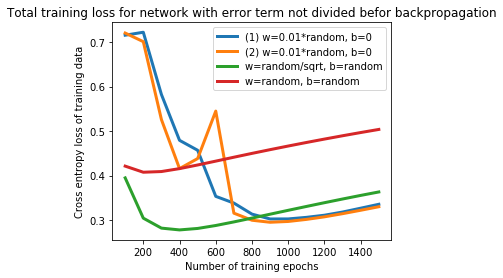

In [128]:
line_w0, = plt.plot(epochs[1:], track_error_term_not_div_w0[2][1:])
line_w1, = plt.plot(epochs[1:], track_error_term_not_div_w1[2][1:])
line_w2, = plt.plot(epochs[1:], track_error_term_not_div_w2[2][1:])
line_w3, = plt.plot(epochs[1:], track_error_term_not_div_w3[2][1:])
plt.title("Total training loss for network with error term not divided befor backpropagation")
plt.xlabel("Number of training epochs")
plt.ylabel("Cross entropy loss of training data")
plt.setp([line_w0, line_w1, line_w2, line_w3], 'linewidth', 3.0)
plt.legend([line_w0, line_w1, line_w2, line_w3], \
           ['(1) w=0.01*random, b=0', '(2) w=0.01*random, b=0',\
            'w=random/sqrt, b=random','w=random, b=random'])

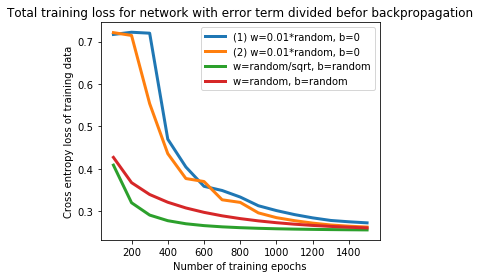

In [129]:
line_w0, = plt.plot(epochs[1:], track_error_term_div_w0[2][1:])
line_w1, = plt.plot(epochs[1:], track_error_term_div_w1[2][1:])
line_w2, = plt.plot(epochs[1:], track_error_term_div_w2[2][1:])
line_w3, = plt.plot(epochs[1:], track_error_term_div_w3[2][1:])
plt.title("Total training loss for network with error term divided befor backpropagation")
plt.xlabel("Number of training epochs")
plt.ylabel("Cross entropy loss of training data")
plt.setp([line_w0, line_w1, line_w2, line_w3], 'linewidth', 3.0)
plt.legend([line_w0, line_w1, line_w2, line_w3], \
           ['(1) w=0.01*random, b=0', '(2) w=0.01*random, b=0',\
            'w=random/sqrt, b=random','w=random, b=random'])

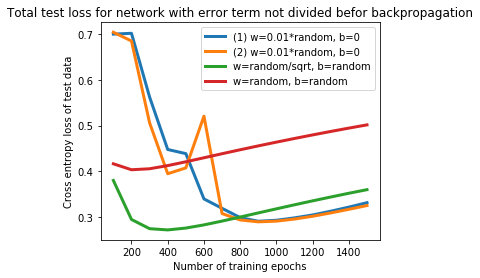

In [136]:
line_w0, = plt.plot(epochs[1:], track_error_term_not_div_w0[5][1:])
line_w1, = plt.plot(epochs[1:], track_error_term_not_div_w1[5][1:])
line_w2, = plt.plot(epochs[1:], track_error_term_not_div_w2[5][1:])
line_w3, = plt.plot(epochs[1:], track_error_term_not_div_w3[5][1:])
plt.title("Total test loss for network with error term not divided befor backpropagation")
plt.xlabel("Number of training epochs")
plt.ylabel("Cross entropy loss of test data")
plt.setp([line_w0, line_w1, line_w2, line_w3], 'linewidth', 3.0)
plt.legend([line_w0, line_w1, line_w2, line_w3], \
           ['(1) w=0.01*random, b=0', '(2) w=0.01*random, b=0',\
            'w=random/sqrt, b=random','w=random, b=random'])

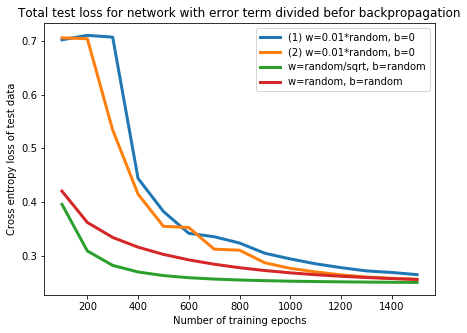

In [146]:
line_w0, = plt.plot(epochs[1:], track_error_term_div_w0[5][1:])
line_w1, = plt.plot(epochs[1:], track_error_term_div_w1[5][1:])
line_w2, = plt.plot(epochs[1:], track_error_term_div_w2[5][1:])
line_w3, = plt.plot(epochs[1:], track_error_term_div_w3[5][1:])
plt.title("Total test loss for network with error term divided befor backpropagation")
plt.xlabel("Number of training epochs")
plt.ylabel("Cross entropy loss of test data")
plt.setp([line_w0, line_w1, line_w2, line_w3], 'linewidth', 3.0)
plt.legend([line_w0, line_w1, line_w2, line_w3], \
           ['(1) w=0.01*random, b=0', '(2) w=0.01*random, b=0',\
            'w=random/sqrt, b=random','w=random, b=random'])

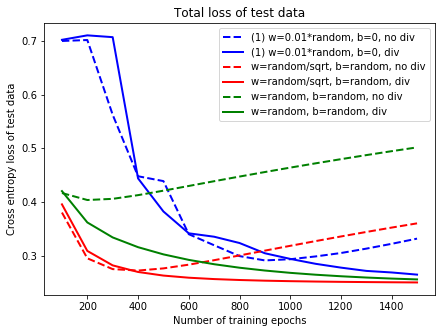

In [157]:
idx=5 # Index 5 of total loss of test data
line_w01, = plt.plot(epochs[1:], track_error_term_not_div_w0[idx][1:],'--',color='blue')
line_w02, = plt.plot(epochs[1:], track_error_term_div_w0[idx][1:], color='blue')
line_w21, = plt.plot(epochs[1:], track_error_term_not_div_w2[idx][1:],'--',color='red')
line_w22, = plt.plot(epochs[1:], track_error_term_div_w2[idx][1:], color='red')
line_w31, = plt.plot(epochs[1:], track_error_term_not_div_w3[idx][1:],'--',color='green')
line_w32, = plt.plot(epochs[1:], track_error_term_div_w3[idx][1:], color='green')

plt.title("Total loss of test data")
plt.xlabel("Number of training epochs")
plt.ylabel("Cross entropy loss of test data")
plt.setp([line_w01, line_w02, line_w21, line_w22, line_w31, line_w32], 'linewidth', 2.0)
plt.legend([line_w01, line_w02, line_w21, line_w22, line_w31, line_w32], \
           ['(1) w=0.01*random, b=0, no div', '(1) w=0.01*random, b=0, div',\
            'w=random/sqrt, b=random, no div', 'w=random/sqrt, b=random, div',\
            'w=random, b=random, no div', 'w=random, b=random, div'])

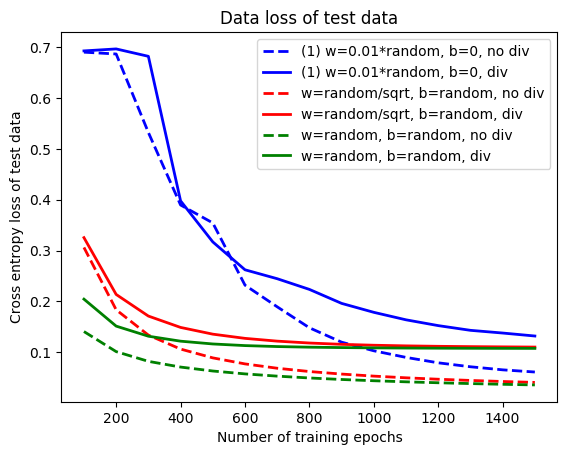

In [321]:
idx=3 # Index 3 of data loss of test data
line_w01, = plt.plot(epochs[1:], track_error_term_not_div_w0[idx][1:],'--',color='blue')
line_w02, = plt.plot(epochs[1:], track_error_term_div_w0[idx][1:], color='blue')
line_w21, = plt.plot(epochs[1:], track_error_term_not_div_w2[idx][1:],'--',color='red')
line_w22, = plt.plot(epochs[1:], track_error_term_div_w2[idx][1:], color='red')
line_w31, = plt.plot(epochs[1:], track_error_term_not_div_w3[idx][1:],'--',color='green')
line_w32, = plt.plot(epochs[1:], track_error_term_div_w3[idx][1:], color='green')

plt.title("Data loss of test data")
plt.xlabel("Number of training epochs")
plt.ylabel("Cross entropy loss of test data")
plt.setp([line_w01, line_w02, line_w21, line_w22, line_w31, line_w32], 'linewidth', 2.0)
plt.legend([line_w01, line_w02, line_w21, line_w22, line_w31, line_w32], \
           ['(1) w=0.01*random, b=0, no div', '(1) w=0.01*random, b=0, div',\
            'w=random/sqrt, b=random, no div', 'w=random/sqrt, b=random, div',\
            'w=random, b=random, no div', 'w=random, b=random, div'])

In [164]:
# Customizing plots with style sheets
#https://matplotlib.org/users/style_sheets.html
print(plt.style.available)

['dark_background', 'fivethirtyeight', 'seaborn-ticks', '_classic_test', 'ggplot', 'seaborn-muted', 'seaborn-paper', 'seaborn-bright', 'seaborn-dark-palette', 'seaborn', 'seaborn-notebook', 'grayscale', 'seaborn-poster', 'seaborn-pastel', 'seaborn-dark', 'seaborn-talk', 'seaborn-white', 'classic', 'seaborn-darkgrid', 'seaborn-deep', 'bmh', 'seaborn-colorblind', 'seaborn-whitegrid']


#### Capaign to collect data without regularizer

In [224]:
# __init__(self, sizes, cost=CrossEntropyCost, error_term_divided=1, weight_init=0, regOn=1)
# Error term is not divided by mini batch size. Only dW is divided by mini batch 
# size during weight update step. Reqularizer is disabled
# Weights are initialized in cs321 style (old style)
net_error_term_not_div_w0_regOff = Network([2, 100, 3], CrossEntropyCost, 0, 0, 0)
net_error_term_div_w0_regOff = Network([2, 100, 3], CrossEntropyCost, 1, 0, 0)
# Weights are initilaized in smart random way
net_error_term_not_div_w2_regOff = Network([2, 100, 3], CrossEntropyCost, 0, 2, 0)
net_error_term_div_w2_regOff = Network([2, 100, 3], CrossEntropyCost, 1, 2, 0)
# Weights are initilaized random way
net_error_term_not_div_w3_regOff = Network([2, 100, 3], CrossEntropyCost, 0, 3, 0)
net_error_term_div_w3_regOff = Network([2, 100, 3], CrossEntropyCost, 1, 3, 0)

Reg loss w1:  9.51485768393e-06
Reg loss w2:  1.57128690351e-05
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 3]
Cost function: <class '__main__.CrossEntropyCost'>
 Layer 1  (the first hidden layer)
   Biases:   100 1
   Weights:  100 2
 Layer 2  (output layer)
   Biases:   3 1
   Weights:  3 100
Time of initialization:  0.0030851364135742188
Reg loss w1:  9.51485768393e-06
Reg loss w2:  1.57128690351e-05
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 3]
Cost function: <class '__main__.CrossEntropyCost'>
 Layer 1  (the first hidden layer)
   Biases:   100 1
   Weights:  100 2
 Layer 2  (output layer)
   Biases:   3 1
   Weights:  3 100
Time of initialization:  0.008818626403808594
Reg loss w1:  0.0387288628479
Reg loss w2:  0.00136555349324
Number of layers (input, hidden, output):  3
Indexing of layers: 0.. 2
Number of neurons in each layer:  [2, 100, 

In [225]:
# error term: divided/not divided, Weight random simple (w=0.01*random, b=0),regularizer OFF
track_error_term_not_div_w0_regOff = \
net_error_term_not_div_w0_regOff.SGD(training_data, 1500, 400, 1.0,100, test_data)
track_error_term_div_w0_regOff = \
net_error_term_div_w0_regOff.SGD(training_data, 1500, 400, 1.0,100, test_data)

# error term: divided/not divided, Weight smart random (w=random/sqrt, b=random),reg OFF
track_error_term_not_div_w2_regOff = \
net_error_term_not_div_w2_regOff.SGD(training_data, 1500, 400, 1.0,100, test_data)
track_error_term_div_w2_regOff = \
net_error_term_div_w2_regOff.SGD(training_data, 1500, 400, 1.0,100, test_data)

# error term: divided/not divided, Weight random (w=random, b=random),reg OFF
track_error_term_not_div_w3_regOff = \
net_error_term_not_div_w3_regOff.SGD(training_data, 1500, 400, 1.0,100, test_data)
track_error_term_div_w3_regOff = \
net_error_term_div_w3_regOff.SGD(training_data, 1500, 400, 1.0,100, test_data)

Number of all training samples: 300
Size of the first mini batch:  300
Epoch 0: Data loss: 1.0987, Reg loss: 0.0000, Total loss: 1.09869029,  Av time: 0.00000
Epoch 100: Data loss: 0.7058, Reg loss: 0.0095, Total loss: 0.71525731,  Av time: 0.03220
Epoch 200: Data loss: 0.7059, Reg loss: 0.0149, Total loss: 0.72077836,  Av time: 0.03499
Epoch 300: Data loss: 0.5666, Reg loss: 0.0300, Total loss: 0.59656508,  Av time: 0.03458
Epoch 400: Data loss: 0.4282, Reg loss: 0.0584, Total loss: 0.48657074,  Av time: 0.03232
Epoch 500: Data loss: 0.3255, Reg loss: 0.0847, Total loss: 0.41022333,  Av time: 0.03590
Epoch 600: Data loss: 0.2328, Reg loss: 0.1084, Total loss: 0.34118235,  Av time: 0.03183
Epoch 700: Data loss: 0.2055, Reg loss: 0.1301, Total loss: 0.33561703,  Av time: 0.03179
Epoch 800: Data loss: 0.1621, Reg loss: 0.1514, Total loss: 0.31355006,  Av time: 0.03197
Epoch 900: Data loss: 0.1298, Reg loss: 0.1718, Total loss: 0.30162221,  Av time: 0.03174
Epoch 1000: Data loss: 0.1122, 

Epoch 700: Data loss: 0.0587, Reg loss: 0.3813, Total loss: 0.44003870,  Av time: 0.03473
Epoch 800: Data loss: 0.0544, Reg loss: 0.3946, Total loss: 0.44903557,  Av time: 0.03550
Epoch 900: Data loss: 0.0510, Reg loss: 0.4069, Total loss: 0.45792274,  Av time: 0.03747
Epoch 1000: Data loss: 0.0481, Reg loss: 0.4185, Total loss: 0.46659036,  Av time: 0.03488
Epoch 1100: Data loss: 0.0457, Reg loss: 0.4293, Total loss: 0.47501698,  Av time: 0.03590
Epoch 1200: Data loss: 0.0436, Reg loss: 0.4396, Total loss: 0.48320180,  Av time: 0.03588
Epoch 1300: Data loss: 0.0419, Reg loss: 0.4493, Total loss: 0.49114929,  Av time: 0.03819
Epoch 1400: Data loss: 0.0403, Reg loss: 0.4586, Total loss: 0.49885753,  Av time: 0.03700
Epoch 1499: Data loss: 0.0389, Reg loss: 0.4674, Total loss: 0.50626467,  Av time: 0.03401


In [204]:
plt.rcParams['figure.figsize'] = (12.0, 6.0) # set default size of plots

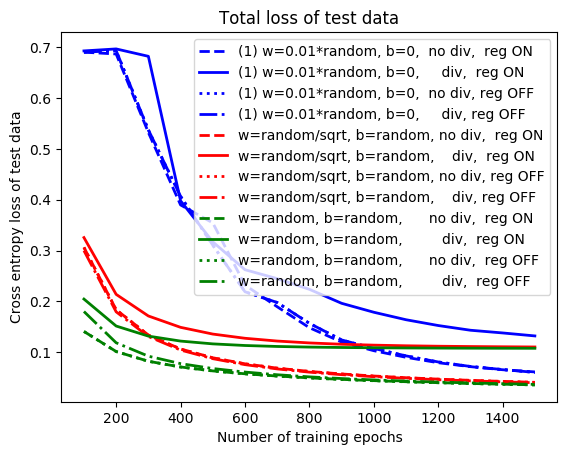

In [319]:
idx=3 # Index 5 of total loss of test data
line_w01, = plt.plot(epochs[1:], track_error_term_not_div_w0[idx][1:],'--',color='blue')
line_w02, = plt.plot(epochs[1:], track_error_term_div_w0[idx][1:], color='blue')
line_w03, = plt.plot(epochs[1:], track_error_term_not_div_w0_regOff[idx][1:],':',color='blue')
line_w04, = plt.plot(epochs[1:], track_error_term_div_w0_regOff[idx][1:], '-.',color='blue')

line_w21, = plt.plot(epochs[1:], track_error_term_not_div_w2[idx][1:],'--',color='red')
line_w22, = plt.plot(epochs[1:], track_error_term_div_w2[idx][1:], color='red')
line_w23, = plt.plot(epochs[1:], track_error_term_not_div_w2_regOff[idx][1:],':',color='red')
line_w24, = plt.plot(epochs[1:], track_error_term_div_w2_regOff[idx][1:], '-.',color='red')

line_w31, = plt.plot(epochs[1:], track_error_term_not_div_w3[idx][1:],'--',color='green')
line_w32, = plt.plot(epochs[1:], track_error_term_div_w3[idx][1:], color='green')
line_w33, = plt.plot(epochs[1:], track_error_term_not_div_w3_regOff[idx][1:],':',color='green')
line_w34, = plt.plot(epochs[1:], track_error_term_div_w3_regOff[idx][1:], '-.',color='green')

plt.title("Total loss of test data")
plt.xlabel("Number of training epochs")
plt.ylabel("Cross entropy loss of test data")
plt.setp([line_w01, line_w02, line_w03, line_w04, line_w21, line_w22, \
          line_w23, line_w24, line_w31, line_w32, line_w33, line_w34], 'linewidth', 2.0)
plt.legend([line_w01, line_w02, line_w03, line_w04, line_w21, line_w22, \
            line_w23, line_w24, line_w31, line_w32, line_w33, line_w34],\
           ['(1) w=0.01*random, b=0,  no div,  reg ON', '(1) w=0.01*random, b=0,     div,  reg ON',\
            '(1) w=0.01*random, b=0,  no div, reg OFF', '(1) w=0.01*random, b=0,     div, reg OFF',\
            'w=random/sqrt, b=random, no div,  reg ON', 'w=random/sqrt, b=random,    div,  reg ON',\
            'w=random/sqrt, b=random, no div, reg OFF', 'w=random/sqrt, b=random,    div, reg OFF',\
            'w=random, b=random,      no div,  reg ON', 'w=random, b=random,         div,  reg ON',\
            'w=random, b=random,      no div,  reg OFF', 'w=random, b=random,         div,  reg OFF'])

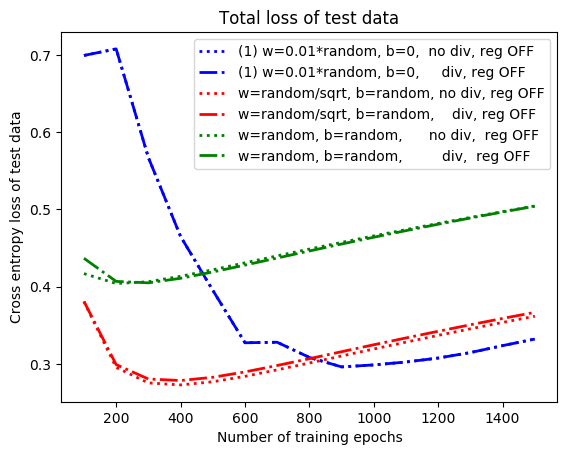

In [320]:
idx=5 # Index 5 of total loss of test data
line_w03, = plt.plot(epochs[1:], track_error_term_not_div_w0_regOff[idx][1:],':',color='blue')
line_w04, = plt.plot(epochs[1:], track_error_term_div_w0_regOff[idx][1:], '-.',color='blue')

line_w23, = plt.plot(epochs[1:], track_error_term_not_div_w2_regOff[idx][1:],':',color='red')
line_w24, = plt.plot(epochs[1:], track_error_term_div_w2_regOff[idx][1:], '-.',color='red')

line_w33, = plt.plot(epochs[1:], track_error_term_not_div_w3_regOff[idx][1:],':',color='green')
line_w34, = plt.plot(epochs[1:], track_error_term_div_w3_regOff[idx][1:], '-.',color='green')

plt.title("Total loss of test data")
plt.xlabel("Number of training epochs")
plt.ylabel("Cross entropy loss of test data")
plt.setp([line_w03, line_w04, line_w23, line_w24, line_w33, line_w34], 'linewidth', 2.0)
plt.legend([line_w03, line_w04, line_w23, line_w24, line_w33, line_w34],\
           ['(1) w=0.01*random, b=0,  no div, reg OFF', '(1) w=0.01*random, b=0,     div, reg OFF',\
            'w=random/sqrt, b=random, no div, reg OFF', 'w=random/sqrt, b=random,    div, reg OFF',\
            'w=random, b=random,      no div,  reg OFF', 'w=random, b=random,         div,  reg OFF'])

In [285]:
def calcAccuracy(netResul, data):
    # Accurasy calculation
    
    W_all = netResul[6]
    b_all = netResul[7]
    W1 = W_all[0]
    b1 = b_all[0]
    W2 = W_all[1]
    b2 = b_all[1]
    
    # Decouple input data into X (input) and Y (label)
    num_of_samples = len(data)
    Xin = [x_1[0] for x_1 in data ]
    Xin = np.array(Xin)
    Xin = np.reshape(Xin, (num_of_samples, -1))
    Yin = [x_1[1] for x_1 in data ]
    Yin = np.array(Yin)
    Yin = np.reshape(Yin, (num_of_samples, -1))
    
    # Calcualte scores using trained weights and bias
    # hidden_layer = [100, n]  n - number of data samples
    hidden_layer = np.maximum(0, np.dot(W1, Xin.T) + b1)
    # AfterTrainScores = [3, n]
    AfterTrainScores = np.dot(W2, hidden_layer) + b2
    # Returns the indices of the maximum values along an axis.
    predicted_class = np.argmax(AfterTrainScores, axis=0)
    result = np.mean( predicted_class == y)
    return result

In [289]:
calcAccuracy(track_error_term_not_div_w3_regOff, test_data)

0.99333333333333329

In [307]:
accuracy_regOn = list()
accuracy_regOn.append( calcAccuracy(track_error_term_not_div_w0, test_data) )
accuracy_regOn.append( calcAccuracy(track_error_term_div_w0, test_data) )

#accuracy_regOn.append( calcAccuracy(track_error_term_not_div_w1, test_data) )
#accuracy_regOn.append( calcAccuracy(track_error_term_div_w1, test_data) )

accuracy_regOn.append( calcAccuracy(track_error_term_not_div_w2, test_data) )
accuracy_regOn.append( calcAccuracy(track_error_term_div_w2, test_data) )

accuracy_regOn.append( calcAccuracy(track_error_term_not_div_w3, test_data) )
accuracy_regOn.append( calcAccuracy(track_error_term_div_w3, test_data) )

In [308]:
accuracy_regOff = list()
accuracy_regOff.append( calcAccuracy(track_error_term_not_div_w0_regOff, test_data) )
accuracy_regOff.append( calcAccuracy(track_error_term_div_w0_regOff, test_data) )

accuracy_regOff.append( calcAccuracy(track_error_term_not_div_w2_regOff, test_data) )
accuracy_regOff.append( calcAccuracy(track_error_term_div_w2_regOff, test_data) )

accuracy_regOff.append( calcAccuracy(track_error_term_not_div_w3_regOff, test_data) )
accuracy_regOff.append( calcAccuracy(track_error_term_div_w3_regOff, test_data) )

In [309]:
accuracy_regOn

[0.98999999999999999,
 0.96999999999999997,
 0.99333333333333329,
 0.98999999999999999,
 0.99333333333333329,
 0.98999999999999999]

In [310]:
accuracy_regOff

[0.98666666666666669,
 0.98666666666666669,
 0.99333333333333329,
 0.99333333333333329,
 0.99333333333333329,
 0.99333333333333329]

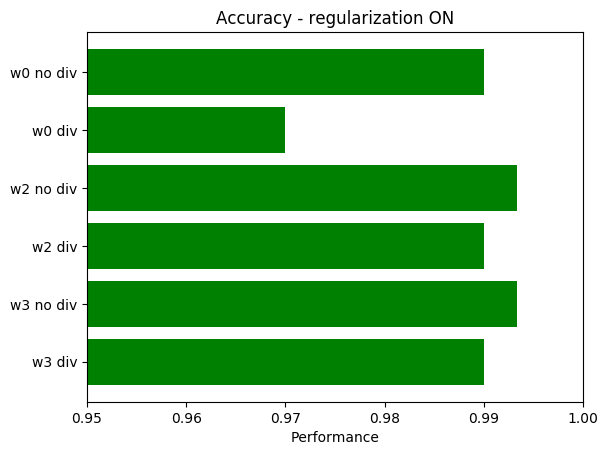

In [314]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
nets = ('w0 no div', 'w0 div', 'w2 no div', 'w2 div', 'w3 no div', 'w3 div')
y_pos = np.arange(len(nets))
performance = accuracy_regOn

ax.barh(y_pos, performance, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(nets)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Accuracy - regularization ON')
plt.xlim([0.95,1.0])

plt.show()

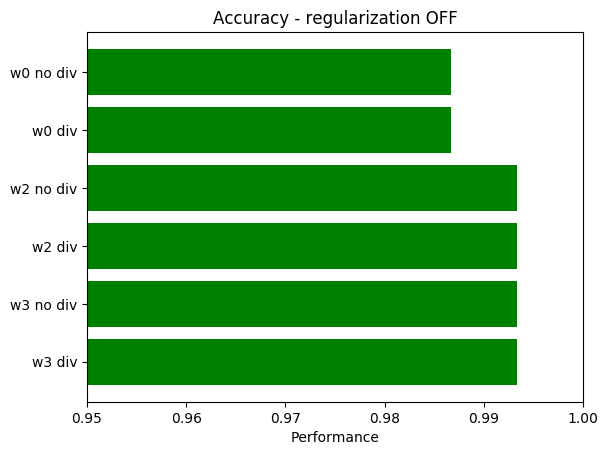

In [315]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
nets = ('w0 no div', 'w0 div', 'w2 no div', 'w2 div', 'w3 no div', 'w3 div')
y_pos = np.arange(len(nets))
performance = accuracy_regOff

ax.barh(y_pos, performance, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(nets)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Accuracy - regularization OFF')
plt.xlim([0.95,1.0])

plt.show()

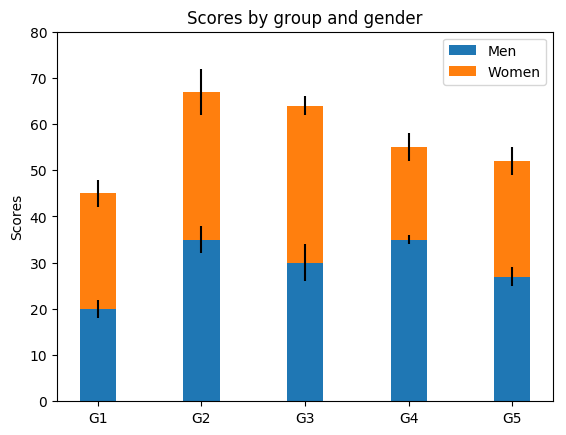

In [323]:
N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

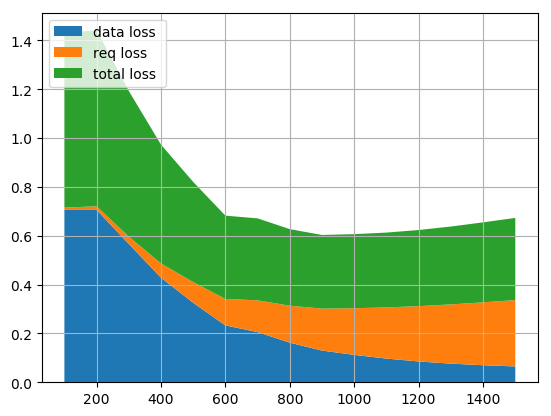

In [385]:
x = epochs[1:]
xPlot = np.vstack(x) # chnge 0-dim list to array
xPlot = xPlot.T

data_loss_w0_regOff = track_error_term_not_div_w0_regOff[0][1:].T
reg_los_w0_regOff = track_error_term_not_div_w0_regOff[1][1:].T
total_loss_w0_regOff = track_error_term_not_div_w0_regOff[2][1:].T

y = np.concatenate([data_loss_w0_regOff, \
                    reg_los_w0_regOff, \
                    total_loss_w0_regOff], axis=0)

labels = ["data loss ", "req loss", "total loss"]

#fig, ax = plt.subplots()
#ax.stackplot(x, data_loss_w0_regOff, reg_los_w0_regOff, total_loss_w0_regOff, labels=labels)
#ax.legend(loc=2)
#plt.grid()
#plt.show()

fig, ax = plt.subplots()
ax.stackplot(x, y, labels=labels)
ax.legend(loc=2)
plt.grid()
plt.show()

#http://www.futurile.net/2016/03/31/colormaps-in-matplotlib/

In [ ]:
http://benalexkeen.com/bar-charts-in-matplotlib/
http://pandas.pydata.org/pandas-docs/stable/visualization.html#bar-plots
https://stackoverflow.com/questions/16653815/horizontal-stacked-bar-chart-in-matplotlib
https://matplotlib.org/2.0.2/users/recipes.html


In [ ]:
line_w03, = plt.plot(epochs[1:], track_error_term_not_div_w0_regOff[idx][1:],':',color='blue')
line_w04, = plt.plot(epochs[1:], track_error_term_div_w0_regOff[idx][1:], '-.',color='blue')

line_w23, = plt.plot(epochs[1:], track_error_term_not_div_w2_regOff[idx][1:],':',color='red')
line_w24, = plt.plot(epochs[1:], track_error_term_div_w2_regOff[idx][1:], '-.',color='red')


In [327]:
len(track_error_term_not_div_w0_regOff)

8

(-1.8986742916067261, 1.9413257083932773)

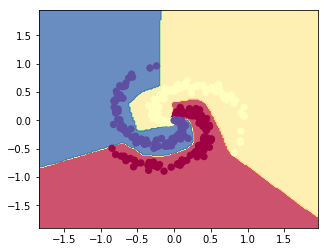

In [100]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
W = net_error_term_not_div_w0.weights[0]
b = net_error_term_not_div_w0.biases[0]
W2 = net_error_term_not_div_w0.weights[1]
b2 = net_error_term_not_div_w0.biases[1]
Z1 = np.maximum(0, np.dot(W, np.c_[xx.ravel(), yy.ravel()].T) + b)
Z = np.dot(W2,Z1)  + b2
Z = np.argmax(Z, axis=0)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

(-1.8986742916067261, 1.9413257083932773)

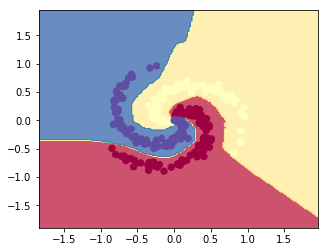

In [101]:
# Plot with orygina weight update
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
W = net_error_term_not_div_w3.weights[0]
b = net_error_term_not_div_w3.biases[0]
W2 = net_error_term_not_div_w3.weights[1]
b2 = net_error_term_not_div_w3.biases[1]
Z1 = np.maximum(0, np.dot(W, np.c_[xx.ravel(), yy.ravel()].T) + b)
Z = np.dot(W2,Z1)  + b2
Z = np.argmax(Z, axis=0)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

(-1.8986742916067261, 1.9413257083932773)

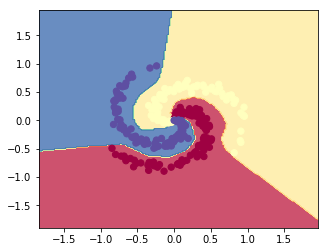

In [105]:
# Plot with orygina weight update
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
W = net_error_term_not_div_w2.weights[0]
b = net_error_term_not_div_w2.biases[0]
W2 = net_error_term_not_div_w2.weights[1]
b2 = net_error_term_not_div_w2.biases[1]
Z1 = np.maximum(0, np.dot(W, np.c_[xx.ravel(), yy.ravel()].T) + b)
Z = np.dot(W2,Z1)  + b2
Z = np.argmax(Z, axis=0)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

(-1.8986742916067261, 1.9413257083932773)

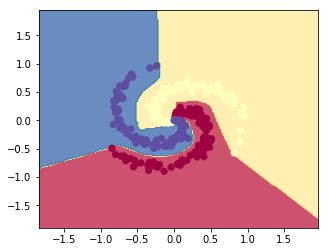

In [102]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
W = net_error_term_div_w0.weights[0]
b = net_error_term_div_w0.biases[0]
W2 = net_error_term_div_w0.weights[1]
b2 = net_error_term_div_w0.biases[1]
Z1 = np.maximum(0, np.dot(W, np.c_[xx.ravel(), yy.ravel()].T) + b)
Z = np.dot(W2,Z1)  + b2
Z = np.argmax(Z, axis=0)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

(-1.8986742916067261, 1.9413257083932773)

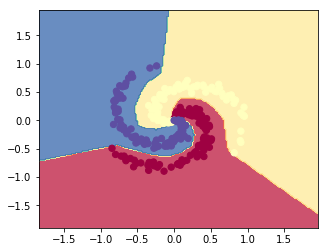

In [103]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
W = net_error_term_div_w3.weights[0]
b = net_error_term_div_w3.biases[0]
W2 = net_error_term_div_w3.weights[1]
b2 = net_error_term_div_w3.biases[1]
Z1 = np.maximum(0, np.dot(W, np.c_[xx.ravel(), yy.ravel()].T) + b)
Z = np.dot(W2,Z1)  + b2
Z = np.argmax(Z, axis=0)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

(-1.8986742916067261, 1.9413257083932773)

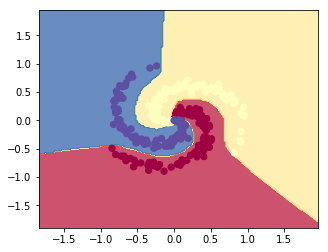

In [104]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
W = net_error_term_div_w2.weights[0]
b = net_error_term_div_w2.biases[0]
W2 = net_error_term_div_w2.weights[1]
b2 = net_error_term_div_w2.biases[1]
Z1 = np.maximum(0, np.dot(W, np.c_[xx.ravel(), yy.ravel()].T) + b)
Z = np.dot(W2,Z1)  + b2
Z = np.argmax(Z, axis=0)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')